In [1]:
from typing import Tuple
import torch
import torch.nn.functional as F
import copy
import numpy as np
import torchvision
import torchvision.transforms 
import math
import e2cnn.nn as enn
from e2cnn.nn import init
from e2cnn import gspaces
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import json
import torch
import pickle
from functions import *
from torch.utils.data import TensorDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Conv(enn.EquivariantModule):
    """(Convolution2d + BatchNormalization + ReLU) * 2"""
    def __init__(self, in_type, out_type):
        super(Conv, self).__init__()
        
            
        self.conv = enn.SequentialModule(
            enn.R2Conv(in_type, out_type, kernel_size=3, stride=1, padding=0),
            enn.InnerBatchNorm(out_type),
            enn.ReLU(out_type)
        )
    
    
    def forward(self, input):
        return self.conv(input)
    
    
    def evaluate_output_shape(self, input_shape: Tuple):
        assert len(input_shape) == 4
        assert input_shape[1] == self.in_type.size
        return input_shape
        

        
class DownSample(enn.EquivariantModule):
    """Downscale with maxpool, convolution afterwards"""
    def __init__(self, in_type, out_type):
        super(DownSample, self).__init__()
        
        
        self.pool = enn.PointwiseMaxPoolAntialiased(in_type, kernel_size=2, stride=2)
        self.conv = Conv(in_type, out_type)
        
    
    
    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x
    
    
    def evaluate_output_shape(self, input_shape: Tuple):
        assert len(input_shape) == 4
        assert input_shape[1] == self.in_type.size
        return input_shape
        
        
        
class UpSample(torch.nn.Module):
    """cropping -> concatenation -> convolution -> upscaling -> convolution"""
    def __init__(self, in_type, out_type, mid_type, padding=0):
        super(UpSample, self).__init__()
        self.mid_type = mid_type
        self.upsample = enn.R2Upsampling(mid_type, 2)
        self.conv1 = Conv(in_type, mid_type)
        self.conv2 = enn.R2Conv(mid_type, out_type, kernel_size=1)
        self.conv3 = Conv(out_type,out_type)
        
        
        
    def forward(self, x1, x2):
        x1 = x1.tensor
        crop1 = self.center_crop(x1, x2.shape[2:])
        crop1 = enn.GeometricTensor(crop1, self.mid_type)
        concat = enn.tensor_directsum([crop1, x2])
        out = self.conv1(concat)
        out = self.upsample(out)
        out = self.conv2(out)
        out = self.conv3(out)
        return out
    
    
    def evaluate_output_shape(self, input_shape: Tuple):
        assert len(input_shape) == 4
        assert input_shape[1] == self.in_type.size
        return input_shape

    def center_crop(self, layer, target_size):
        """cropping function to get the same size for concatenation"""
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    


class LastConcat(torch.nn.Module):
    """cropping -> concatenation -> double convolution
    since we dont upsample anymore, an extra class must be created"""
    def __init__(self, in_type, out_type, mid_type, padding=0):
        super(LastConcat, self).__init__()
        self.mid_type = mid_type
        self.conv1 = Conv(in_type, mid_type)
        self.conv2 = enn.R2Conv(mid_type, out_type, kernel_size=1, stride=1, padding=0)
        
        
    def forward(self, x1, x2):
        x1 = x1.tensor
        crop1 = self.center_crop(x1, x2.shape[2:])
        crop1 = enn.GeometricTensor(crop1, self.mid_type)
        concat = enn.tensor_directsum([crop1, x2])
        out = self.conv1(concat)
        out = self.conv2(out)
        
        return out
    
    
    def evaluate_output_shape(self, input_shape: Tuple):
        assert len(input_shape) == 4
        assert input_shape[1] == self.in_type.size
        return input_shape

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    
    
    
class UNet(torch.nn.Module):
    """DeepCFD-like UNet, they used three encoders since it worked best in their paper, therefore I did the same"""
    def __init__(self):
        super(UNet, self).__init__()
        
        self.r2_act = gspaces.Rot2dOnR2(N=8)
        
        self.field_type_1 = enn.FieldType(self.r2_act, 1*[self.r2_act.regular_repr])
        self.field_type_3 = enn.FieldType(self.r2_act, 3*[self.r2_act.trivial_repr])
        self.field_type_8 = enn.FieldType(self.r2_act, 8*[self.r2_act.regular_repr])
        self.field_type_16 = enn.FieldType(self.r2_act, 16*[self.r2_act.regular_repr])
        self.field_type_32 = enn.FieldType(self.r2_act, 32*[self.r2_act.regular_repr])
        self.field_type_64 = enn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.field_type_128 = enn.FieldType(self.r2_act, 128*[self.r2_act.regular_repr])
        
        self.conv1 = Conv(in_type = self.field_type_3, out_type = self.field_type_8)
        self.conv2 = Conv(in_type = self.field_type_8, out_type = self.field_type_8)
        
        self.down1 = DownSample(in_type = self.field_type_8, out_type = self.field_type_16)
        self.conv12 = Conv(in_type = self.field_type_16, out_type = self.field_type_16)
        self.down2 = DownSample(in_type = self.field_type_16, out_type = self.field_type_32)
        self.conv22 = Conv(in_type = self.field_type_32, out_type = self.field_type_32)
        self.down3 = DownSample(in_type = self.field_type_32, out_type = self.field_type_32)
        self.conv32 = Conv(in_type = self.field_type_32, out_type = self.field_type_32)
        
        self.up41 = UpSample(in_type = self.field_type_64, out_type = self.field_type_32, mid_type = self.field_type_32)
        self.up31 = UpSample(in_type = self.field_type_64, out_type = self.field_type_16, mid_type = self.field_type_32)
        self.up21 = UpSample(in_type = self.field_type_32, out_type = self.field_type_8, mid_type = self.field_type_16)
        self.up11 = LastConcat(in_type = self.field_type_16, out_type = self.field_type_1, mid_type = self.field_type_8)
        
        self.up42 = UpSample(in_type = self.field_type_64, out_type = self.field_type_32, mid_type = self.field_type_32)
        self.up32 = UpSample(in_type = self.field_type_64, out_type = self.field_type_16, mid_type = self.field_type_32)
        self.up22 = UpSample(in_type = self.field_type_32, out_type = self.field_type_8, mid_type = self.field_type_16)
        self.up12 = LastConcat(in_type = self.field_type_16, out_type = self.field_type_1, mid_type = self.field_type_8)
        
        self.up43 = UpSample(in_type = self.field_type_64, out_type = self.field_type_32, mid_type = self.field_type_32)
        self.up33 = UpSample(in_type = self.field_type_64, out_type = self.field_type_16, mid_type = self.field_type_32)
        self.up23 = UpSample(in_type = self.field_type_32, out_type = self.field_type_8, mid_type = self.field_type_16)
        self.up13 = LastConcat(in_type = self.field_type_16, out_type = self.field_type_1, mid_type = self.field_type_8)
        
        self.gpool1 = enn.GroupPooling(self.field_type_1)
        self.gpool2 = enn.GroupPooling(self.field_type_1)
        self.gpool3 = enn.GroupPooling(self.field_type_1)
        
        
    def forward(self, x):
        x = x.reshape((-1,x.shape[1],x.shape[2],x.shape[3]))   
        x = enn.GeometricTensor(x, self.field_type_3)
        
        x1 = self.conv1(x) 
        x2 = self.conv2(x1)
        
        x2 = self.down1(x2) 
        x3 = self.conv12(x2)
        
        x4 = self.down2(x3) 
        x5 = self.conv22(x4)
        
        x6 = self.down3(x5) 
        x7 = self.conv32(x6)
        
        x8_1 = self.up41(x6, x7)
        x9_1 = self.up31(x4, x8_1)
        x10_1 = self.up21(x2, x9_1)
        out1 = self.up11(x1, x10_1)
        out1 = self.gpool1(out1)
        out1 = out1.tensor
        
        x8_2 = self.up42(x6, x7)
        x9_2 = self.up32(x4, x8_2)
        x10_2 = self.up22(x2, x9_2)
        out2 = self.up12(x1, x10_2)
        out2 = self.gpool2(out2)
        out2 = out2.tensor
        
        x8_3 = self.up43(x6, x7)
        x9_3 = self.up33(x4, x8_3)
        x10_3 = self.up23(x2, x9_3)
        out3 = self.up13(x1, x10_3)
        out3 = self.gpool3(out3)
        out3 = out3.tensor
        
        out = torch.cat((out1,out2,out3), dim=1)
        return out
    
    
def run_epoch(model, optimizer, dataloader, train, loss_fnc, length_dataset):
    """running one epoch"""
    
    if train:
        model.train()
    else:
        model.eval()

    epoch_loss = 0.0
    
    mse = 0
    mse_ux = 0
    mse_uy = 0
    mse_p = 0
    # Iterate over data
    for tensors in dataloader:
        tensors = [tensor.to(device) for tensor in tensors]
        
        # zero the parameter gradients
        if train:
            optimizer.zero_grad()

        # forward
        with torch.set_grad_enabled(train):
            loss, lossu, lossv, losspp, output = loss_func(model, tensors)
        
            # backward + optimize only if in training phase
            if train:
                loss.backward()
                optimizer.step()
                
        epoch_loss += loss.item()
        mse += torch.sum(lossu + lossv + losspp)
        mse_ux += torch.sum(lossu)
        mse_uy += torch.sum(lossv)
        mse_p += torch.sum(losspp)
        
    #MSE for the whole dataset
    mse = mse/length_dataset
    mse_ux = mse_ux/length_dataset
    mse_uy = mse_uy/length_dataset
    mse_p = mse_p/length_dataset
    return epoch_loss, mse, mse_ux, mse_uy, mse_p


def loss_func(model, batch):
    """ This is the loss function used in the DeepCFD paper. They did not use the mean squared error for channel p, but a absolute error, because it worked better. Therefore i adapted it and used the same loss function. """
    x, y = batch
    output = model(x)
    mse_u = ((output[:,0,:,:] - y[:,0,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    mse_v = ((output[:,1,:,:] - y[:,1,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    abs_error_p = torch.abs((output[:,2,:,:] - y[:,2,:,:])).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    mse_p = ((output[:,2,:,:] - y[:,2,:,:])**2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    loss = (mse_u + mse_v + abs_error_p)/channels_weights
    return torch.sum(loss), mse_u, mse_v, mse_p, output

In [2]:
model = UNet().to(device)

#data loading
x = pickle.load(open("./dataX.pkl", "rb"))
y = pickle.load(open("./dataY.pkl", "rb"))
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)   
channels_weights = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1).reshape((981*172*79,3)) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
x  = F.pad(x,(50,51,54,54))
y = y[:,:,:,1:77]

#creating the train test data split
train_data, test_data = split_tensors(x, y, ratio=0.7)
train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)        
test_x, test_y = test_dataset[:]

C:\Users\ab93\anaconda3\envs\deepcfd_env\lib\site-packages\e2cnn\nn\modules\r2_conv\basisexpansion_singleblock.py:61: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:20.)
  sampled_basis = sampled_basis[mask, ...]


In [3]:
#loading best model
best = torch.load("best_CFD_model")
model.load_state_dict(best)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)
best_epoch, best_mse, best_mse_ux, best_mse_uy, best_mse_p  = run_epoch(model, None, test_loader, train=False,
                                                                                    loss_fnc =loss_func,
                                                                                   length_dataset =len(test_dataset))


In [4]:
#best Mean Squared Error on validation set
best_mse

tensor(1.8169, device='cuda:0')

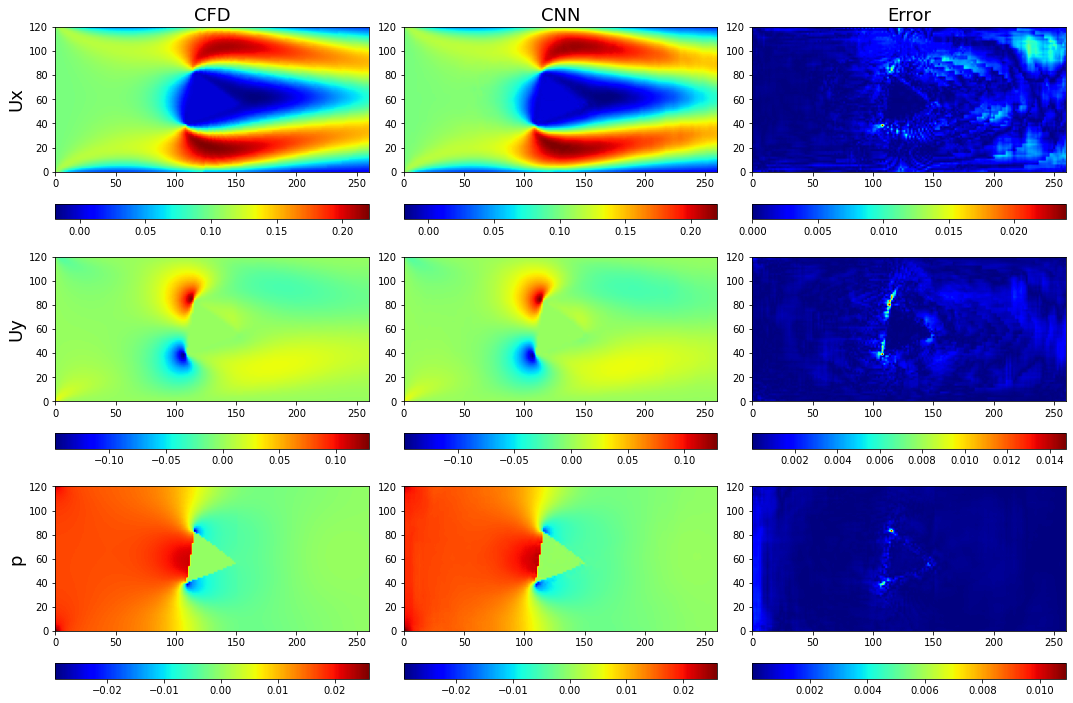

In [5]:
#comparison of real CFD simulation and best-model's output of a test sample and an error map
test_x, test_y = test_dataset[:]
out = model(test_x[:2].to(device))
error = torch.abs(out.cpu() - test_y[:2].cpu())
s = 0
visualize(test_y[:2].cpu().detach().numpy(), out[:2].cpu().detach().numpy(), error[:2].cpu().detach().numpy(), s)

In [6]:
"""this cell is to show that there are two samples in the test set, for which the loss is exceptionally high,
they are very different compared to the usual input samples"""

def loss_func(model, batch):
    x, y = batch
    output = model(x)
    lossu = ((output[:,0,:,:] - y[:,0,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    lossv = ((output[:,1,:,:] - y[:,1,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    lossp = torch.abs((output[:,2,:,:] - y[:,2,:,:])).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    loss = (lossu + lossv + lossp)/channels_weights
    return torch.sum(loss), output

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
with torch.no_grad():
    total_loss = 0
    msetotal = 0
    first =0
    msefirst =0
    b = 0
    for tensors in val_loader:
        tensors = [tensor.to(device) for tensor in tensors]
        loss, ouput = loss_func(model, tensors)
        total_loss += loss.item()
        total=torch.sum((ouput-tensors[1])**2)
        
        if total >=10:
            print("weird sample: " + str(b))
            print("corresponding loss: " + str(total))
            
        b+=1
        
    

weird sample: 105
corresponding loss: tensor(190.4962, device='cuda:0')
weird sample: 190
corresponding loss: tensor(291.8300, device='cuda:0')


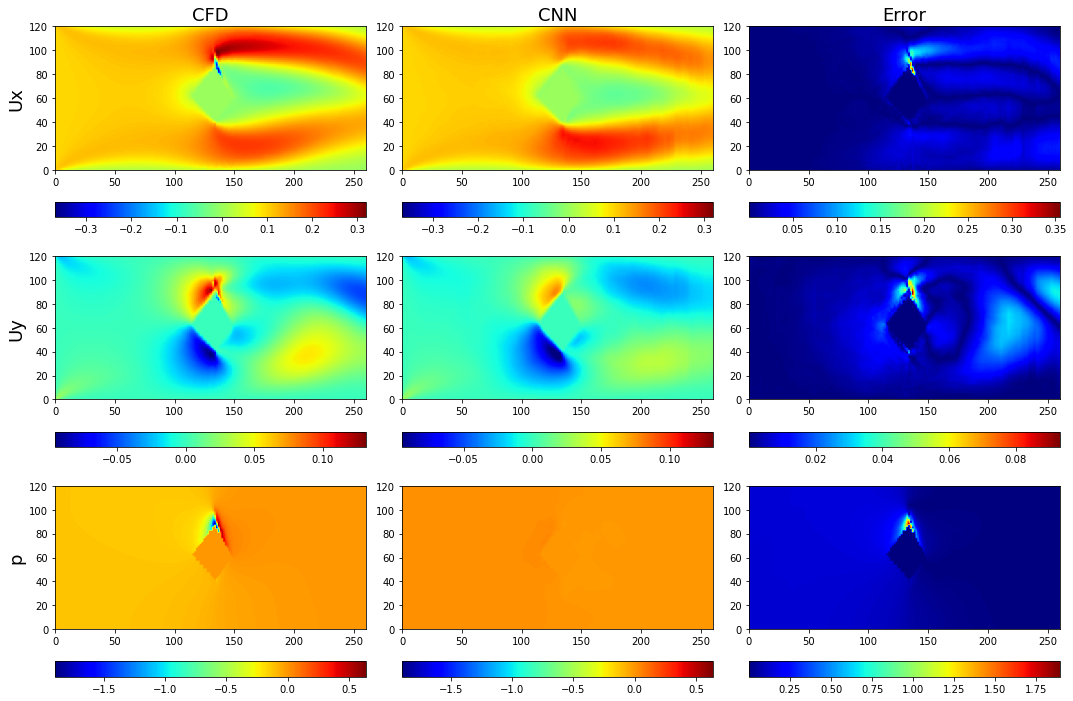

In [7]:
"""sample number 1"""
test_x, test_y = test_dataset[105:106]
out = model(test_x[:2].to(device))
error = torch.abs(out.cpu() - test_y[:2].cpu())
s = 0
visualize(test_y[:2].cpu().detach().numpy(), out[:2].cpu().detach().numpy(), error[:2].cpu().detach().numpy(), s)

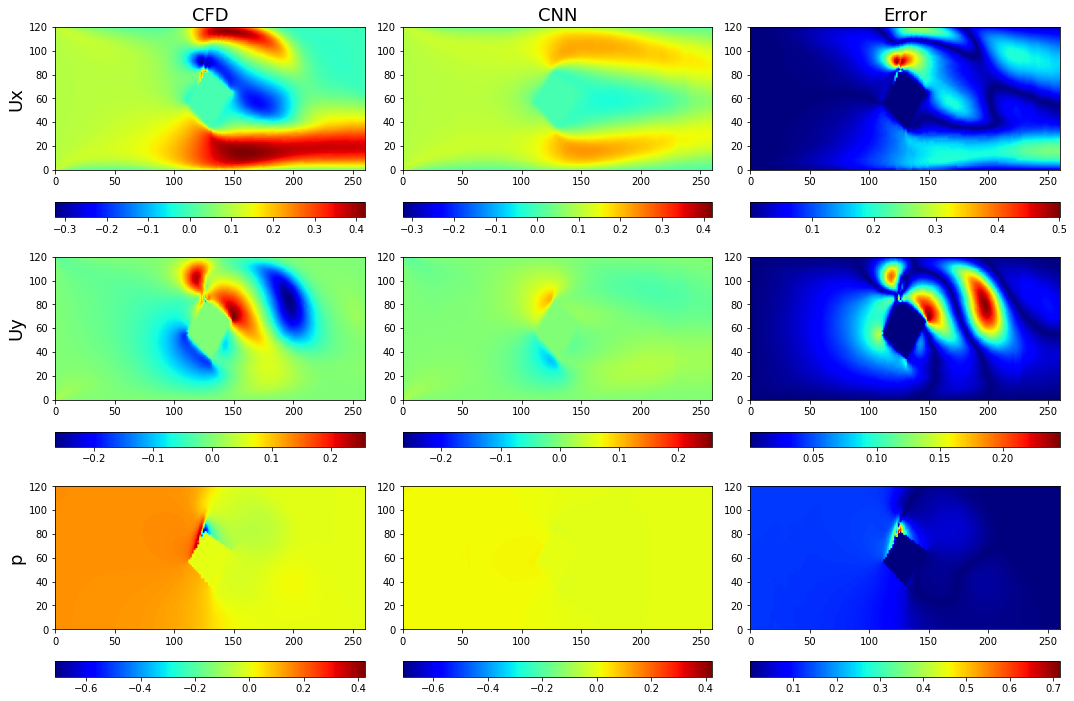

In [8]:
"""sample number 2"""
test_x, test_y = test_dataset[190:191]
out = model(test_x[:2].to(device))
error = torch.abs(out.cpu() - test_y[:2].cpu())
s = 0
visualize(test_y[:2].cpu().detach().numpy(), out[:2].cpu().detach().numpy(), error[:2].cpu().detach().numpy(), s)

In [9]:
"""this cell is to show that there are six samples in the training set, 
for which the loss is exceptionally high, they are very different compared to the usual input samples"""

def loss_func(model, batch):
    x, y = batch
    output = model(x)
    lossu = ((output[:,0,:,:] - y[:,0,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    lossv = ((output[:,1,:,:] - y[:,1,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    lossp = torch.abs((output[:,2,:,:] - y[:,2,:,:])).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    loss = (lossu + lossv + lossp)/channels_weights
    return torch.sum(loss), output

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
with torch.no_grad():
    total_loss = 0
    msetotal = 0
    first =0
    msefirst =0
    b = 0
    for tensors in train_loader:
        tensors = [tensor.to(device) for tensor in tensors]
        loss, ouput = loss_func(model, tensors)
        total_loss += loss.item()
        total=torch.sum((ouput-tensors[1])**2)
        
        if total >=10:
            print("weird sample: " + str(b))
            print("corresponding loss: " + str(total))
            
        b+=1
        
    

weird sample: 16
corresponding loss: tensor(20.5669, device='cuda:0')
weird sample: 226
corresponding loss: tensor(81.6167, device='cuda:0')
weird sample: 283
corresponding loss: tensor(32.1283, device='cuda:0')
weird sample: 351
corresponding loss: tensor(126.1561, device='cuda:0')
weird sample: 403
corresponding loss: tensor(134.8547, device='cuda:0')
weird sample: 484
corresponding loss: tensor(18.8948, device='cuda:0')
